In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())
from tensorflow import GPUOptions, Session, ConfigProto
from keras.preprocessing.image import ImageDataGenerator

# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

gpu_options = GPUOptions(per_process_gpu_memory_fraction = 0.7)       #Assign portion of memory for training this model
sess = Session(config = ConfigProto(gpu_options = gpu_options))

from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import datetime
#Uncomment to run on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [36]:
t = str(datetime.datetime.now())
t=t.replace(' ','-')
t=t.replace(':','-')
NAME = "Galaxy-zoo-"+t
print(NAME)
tensorboard = TensorBoard(log_dir = 'logs\{}'.format(NAME))
DIR = "F:/Projects/Neural Net/Galaxy Zoo/Data/images_training_rev1"

train_path = DIR + "\Train"
validate_path = DIR + "\ValidationFolder"

Galaxy-zoo-2020-04-09-16-19-54.777492


In [37]:
classes = [
    'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1',
    'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3',
    'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3',
    'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
    'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2',
    'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4',
    'Class11.5', 'Class11.6'
]


def append_ext(fn):
    return fn + ".jpg"


traindf = pd.read_csv("F:/Projects/Neural Net/Galaxy Zoo/Data/training_solutions_rev1/training_solutions_rev1.csv")
traindf["id"] = traindf['GalaxyID'].astype(str).apply(append_ext)

datagen = ImageDataGenerator(
    fill_mode='nearest',
    cval=0,
    rescale=1. / 255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split = 0.2,
)



In [44]:
train_generator = datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=train_path,
    x_col="id",
    y_col=classes,
    subset="training",
    batch_size=8,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224, 224))


STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size

Found 49263 validated image filenames.


In [45]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=train_path,
    x_col="id",
    y_col=classes,
    subset="validation",
    batch_size=8,
    seed=123,
    shuffle=True,
    class_mode="raw",
    target_size=(224, 224))

STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Found 12315 validated image filenames.


In [8]:
from keras.models import Sequential, Model,load_model
from keras.applications.resnet import ResNet152
from keras.layers import Add,Input,Dense,Dropout,BatchNormalization,Activation,Flatten,Conv2D,MaxPooling2D,ZeroPadding2D,Lambda,AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from keras.initializers import glorot_uniform

In [9]:
#ResNet Implementation block

def convolution_block(X, f_shape, filters, stage, block, stride = 2):
    '''
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f_shape -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    '''
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    #Main Path
    #first component
    X = Conv2D(filters = F1, kernel_size=(1,1), strides = (stride,stride), name = conv_name_base+'2a', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    #Second Component
    X = Conv2D(filters = F2, kernel_size = (f_shape,f_shape), strides = (1,1), padding = 'same', name = conv_name_base+'2b', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    #Third Component
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base+'2c', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)
    
    #Shortcut Path
    X_shortcut = Conv2D(filters = F3, kernel_size = (1,1), strides = (stride,stride), padding = 'valid', name = conv_name_base+'1',
                       kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base+'1')(X_shortcut)
    
    #Final
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X


def identity_block(X, f_shape, filters, stage, block):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    #Main Path
    #first component
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base+"2a",
              kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    #second component
    X = Conv2D(filters = F2, kernel_size = (f_shape,f_shape), strides = (1,1), padding = 'same', name = conv_name_base+"2b",
              kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    #Third component
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base+'2c',
              kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)
    
    #Final
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


def ResNet50(input_shape = (106,106,3), classes = 37):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    #Create a tensor of shape (106,106,3)
    X_input = Input(input_shape)
    
    #Zero padding to the tensor
    X = ZeroPadding2D((3,3))(X_input)
    
    #Stage 1
    X = Conv2D(64, (7,7), strides = (2,2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides = (2,2))(X)
    
    #Stage 2
    X = convolution_block(X,f_shape = 3, filters = [64,64,256], stage = 2, block = 'a', stride = 1)
    X = identity_block(X, f_shape = 3, filters = [64,64,256], stage = 2, block = 'b')
    X = identity_block(X,3,[64,64,256], stage = 2, block = 'c')
    
    #Stage 3
    X = convolution_block(X, f_shape = 3, filters = [128,128,512], stage = 3, block = 'a', stride = 2)
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'b')
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'c')
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'd')
    
    #Stage 4
    X = convolution_block(X, f_shape = 3, filters = [256,256,1024], stage = 4, block = 'a', stride = 2)
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'b')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'c')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'd')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'e')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'f')
    
    #Stage 5
    X = convolution_block(X, f_shape = 3, filters = [512,512,2048], stage = 5, block = 'a', stride = 2)
    X = identity_block(X, 3, [512,512,2048], stage = 5, block = 'b')
    X = identity_block(X, 3, [512,512,2048], stage = 5, block = 'c')
    
    '''#Stage 6
    X = convolution_block(X, f_shape = 3, filters = [1024,1024,4096], stage = 6, block = 'a', stride = 2)
    X = identity_block(X, 3, [1024,1024,4096], stage = 6, block = 'b')
    X = identity_block(X, 3, [1024,1024,4096], stage = 6, block = 'c')
    X = identity_block(X, 3, [1024,1024,4096], stage = 6, block = 'd')
    X = identity_block(X, 3, [1024,1024,4096], stage = 6, block = 'e')
    X = identity_block(X, 3, [1024,1024,4096], stage = 6, block = 'f')'''
    
    #Average Pooling
    X = AveragePooling2D((2,2), name = "avg_pool")(X)
    
    
    X = Flatten()(X)
    X = Dense(classes, activation = 'sigmoid', name = 'fc'+str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    #create a model instance
    model = Model(inputs = X_input, outputs = X, name = 'ResNet50')
    
    return model

In [10]:
img_shape = (224, 224, 3)

resnet_model = ResNet152(include_top=False, input_shape=img_shape)




A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of ee4c566cf9a93f14d82f913c2dc6dd0c so we will re-download the data.
234700800/234698864 [==============================] - 1448s 6us/step


In [11]:
# Flatten output of last layer before adding output layer (Dense layer)
x = Flatten()(resnet_model.output)

# Add output layer (number of outputs = 37)
x = Dense(len(classes), activation='sigmoid')(x)

# Load the modified model
model = Model(inputs=resnet_model.input, outputs=x)

'''model = ResNet50(input_shape = (224,224,3), classes = 37)

model.compile(optimizer=Adam(lr=0.001, decay=5e-4), loss='mse', metrics=["accuracy"])'''

'model = ResNet50(input_shape = (224,224,3), classes = 37)\n\nmodel.compile(optimizer=Adam(lr=0.001, decay=5e-4), loss=\'mse\', metrics=["accuracy"])'

In [41]:
for layer in model.layers:
    layer.trainable = True
    
if(os.path.isfile("F:/Projects/Neural Net/Galaxy Zoo/Data/weights.hdf5")):
    model.load_weights("weights.hdf5")

optimizer = Adam(lr=0.001, decay=5e-4)

model.compile(optimizer, loss='mse', metrics=["accuracy"])

In [42]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))


early_stopping = EarlyStopping(
    monitor='val_loss', patience=4, verbose=1, mode='auto')

history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='F:/Projects/Neural Net/Galaxy Zoo/Data/weights.hdf5', verbose=2, save_best_only=True)

In [46]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=20,
    callbacks=[history, checkpointer, early_stopping])

Epoch 1/20


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[8,14,14,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_3/Adam/gradients/zeros_177-0-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_3/acc/Mean/_53975]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[8,14,14,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_3/Adam/gradients/zeros_177-0-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

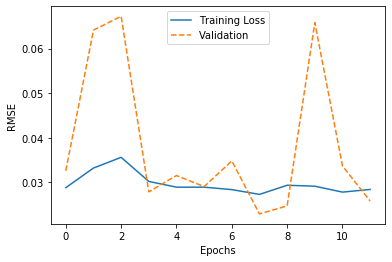

In [31]:
plt.figure()
plt.plot(hist.epoch, hist.history['loss'], label='Training Loss')
plt.plot(
    hist.epoch, hist.history['val_loss'], label='Validation', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [32]:
from keras.models import load_model

model = load_model('weights.hdf5')

In [34]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    "F:/Projects/Neural Net/Galaxy Zoo/Data/images_test_rev1/",
    class_mode=None,
    color_mode="rgb",
    batch_size=1,
    target_size=(224, 224),
    seed=123,
    shuffle=False)

Found 79975 images belonging to 1 classes.


In [35]:
test_generator.reset()

predictions = model.predict_generator(
    test_generator,
    steps=test_generator.n / test_generator.batch_size,
    verbose=1)

print(predictions.shape)

16535/79975 [=====>........................] - ETA: 58:32

KeyboardInterrupt: 

In [ ]:
def get_id(fname):
    return fname.replace(".jpg", "").split("/")[1]


header = open('F:/Projects/Neural Net/Galaxy Zoo/Data/all_zeros_benchmark.csv', 'r').readlines()[0]

with open('Output.csv', 'w') as outfile:
    outfile.write(header)
    for i in range(len(test_generator.filenames)):
        id_ = (get_id(test_generator.filenames[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")